In [57]:
!pip install einops --no-cache-dir
!pip install torch torchvision torchaudio -qqq --no-cache-dir
!pip install tqdm -qqq
!pip install scikit-learn -qqq --no-cache-dir
!pip install torchmetrics --no-cache-dir -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 67.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data
from tqdm import tqdm

# Optimization
This notebook serves as an intro to automatic differentiation in pytorch. We'll start with a basic linear regression model and compare that with a basic MLP. After this we will build a small neural network and probe the impact of basic hyperparameters related to the optimization algorithm.

### Linear Regression
To start off we will revist the small monte carlo dataset generation function.
These values will be the __target__ values for our linear regression, and MLP models to predict.
To be specific, we will give a model 'x' as input and it will predict $\hat{y}$. More formally, our optimization problem will be:

$min    \|y - \hat{y}\|^2 _2$

where $\hat{y} = m*x + b$, for the linear regression problem, or $\hat{y} = MLP(x)$, for the basic MLP model. 

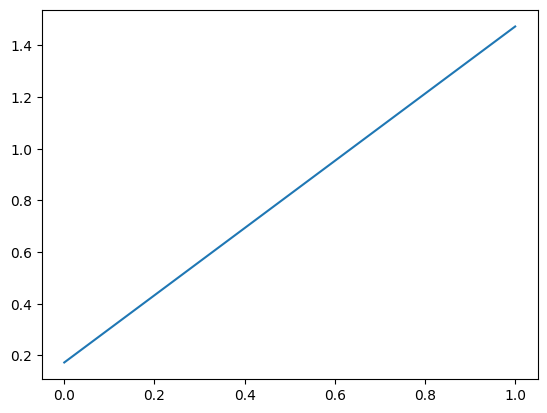

In [9]:
# generate and plot linear regression dataset
def gendata(num_samples):
    x = np.linspace(0,1,num_samples)
    m = 1.3
    b = 0.173
    return x, (m*x)+b

x, y = gendata(500)
plt.plot(x, y)

In [10]:
# Lets initialize the two parameters we would like to use for the optimization
m = np.random.rand()
b = np.random.rand()
print(m, b)

0.10122060645188125 0.660982571421214


In [11]:
y_hat = m*x + b
J = np.mean((y_hat - y)**2)
print('MSE:',J)

MSE: 0.13264753442510827


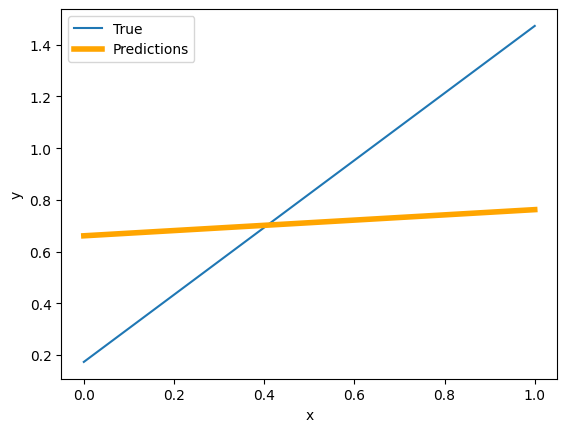

In [12]:
plt.plot(x,y, label='True')
plt.plot(x,y_hat, label='Predictions', color='orange', linewidth=4)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

In [13]:
print(x.shape, x.dtype)
x = torch.tensor(x, requires_grad=True)
print(x.shape, x.dtype)
y_target = torch.tensor(y, requires_grad=True)
print(y.shape, y.dtype)
print(y_target.shape, y_target.dtype)

(500,) float64
torch.Size([500]) torch.float64
(500,) float64
torch.Size([500]) torch.float64


You can learn more about tensors in 
https://pytorch.org/tutorials/beginner/basics/intro.html

In [14]:
m = torch.rand(1,requires_grad=True)
b = torch.rand(1,requires_grad=True)
print(m.shape, b.shape)
print(m, b)

torch.Size([1]) torch.Size([1])
tensor([0.7637], requires_grad=True) tensor([0.8627], requires_grad=True)


In [15]:
x.grad, m.grad, b.grad

(None, None, None)

In [16]:
# compute forward pass
y_hat = m*x + b

In [17]:
J = torch.mean((y_hat - y_target)**2)

In [18]:
J

tensor(0.2018, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [19]:
# compute gradients with respect variables (m, b)
J.backward()

In [21]:
# view gradients of our variables m and b 
m.grad, b.grad

(tensor([0.3319]), tensor([0.8432]))

In [22]:
print(J.grad_fn)  # Shows that J was computed using "PowBackward0"
print(y_hat.grad_fn)  # Shows "AddBackward0" (m*x + b)


In [24]:
# Batch gradient descent
lr = 1E-4
iters = 1000
losses = []
m = torch.rand(1,requires_grad=True)
b = torch.rand(1,requires_grad=True)
for _ in tqdm(range(iters)):
    for i in range(x.shape[0]):
        y_hat = m*x[i] + b
        J = torch.mean((y_hat - y_target[i])**2)
        J.backward()
        # use torch.no_grad to prevent gradient accumulation
        with torch.no_grad():
            m -= m.grad*lr
            b -= b.grad*lr
        m.grad.zero_()
        b.grad.zero_()
    losses.append(J.item())

100%|██████████| 1000/1000 [01:45<00:00,  9.45it/s]


Text(0.5, 0, 'Iterations')

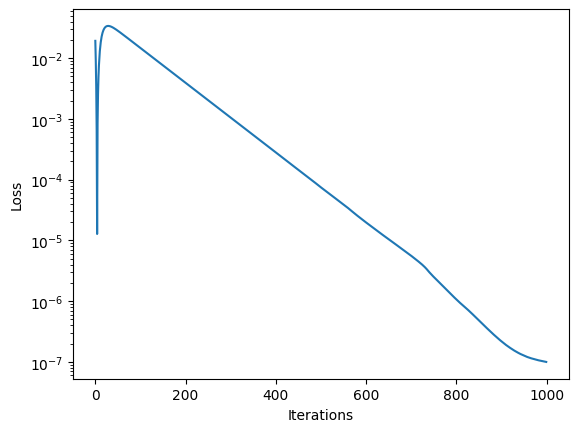

In [26]:
plt.plot(np.arange(iters), losses)
plt.ylabel('Loss')
plt.yscale("log")
plt.xlabel('Iterations')

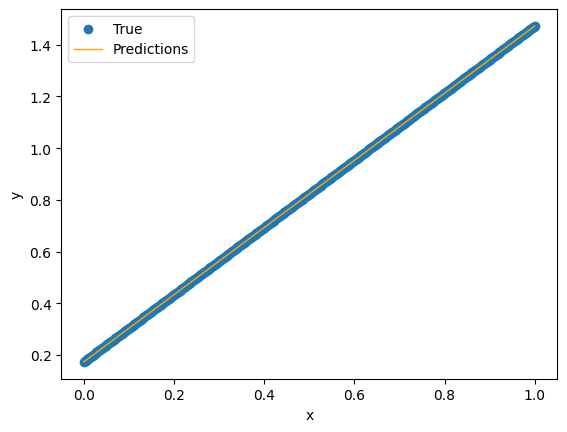

In [27]:
with torch.no_grad():
    y_hat = m * x + b

plt.scatter(x.detach().numpy(),y, label='True')
plt.plot(x.detach().numpy(),y_hat.detach().numpy(), label='Predictions', color='orange', linewidth=1)
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

In [28]:
print('optimized m value    - ', m)
print('optimized b value    - ', b)
#print('ground truth m value -  1.3')
#print('ground truth b value -  0.173')

optimized m value    -  tensor([1.2993], requires_grad=True)
optimized b value    -  tensor([0.1733], requires_grad=True)


### Multi-layer Perceptron (MLP)
MLP's are typically small neural networks. For this specific example we will use a small 2-layer neural network to compare against the basic linear regression model. The main takeaway from this is the expressivity of the MLP, i.e., it is much more flexible, powerful, etc. than the linear regression model because of the introduction of non linear functions. 

In [29]:
# Define our small MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 5)  # input layer to hidden layer
        self.relu = nn.ReLU()       # ReLU nonlinearity
        self.fc2 = nn.Linear(5, 1)  # hidden layer to output layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

You can find more details in
https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [37]:
import torch.nn as nn

criterion = nn.MSELoss()




# Define training loop for MLP
# we will use torch.optim optimizers instead of doing it by hand, as done in the linear regression model

lr = 3e-4
iters = 1000
losses = []

mlp = MLP()
opt = torch.optim.SGD(mlp.parameters(), lr=lr)
print("Number of parameters: ", sum(p.numel() for p in mlp.parameters()))

# tensor dimensions of mlp forward pass for this small network
# [1,1] * [1,5] + [1,5] () ReLU() * [5, 1] + [1,1] = [1,1]
#   x   *   m   +   b   () ReLU() *   m    +   b   = y_hat
#  input  ->   layer_1  ->  nonlin  ->   layer_2   = output

x = x.to(torch.float32).unsqueeze(-1) # x.shape [100]->[100,1] so mlp knows there are 100 samples of 1 scalar value (x)

mlp.train()
for _ in tqdm(range(iters)):
    for i in range(x.shape[0]):
        y_hat = mlp(x[i])
        J = criterion(y_hat.to(torch.float32).squeeze(), y_target[i].to(torch.float32))
        J.backward()
        opt.step()
        opt.zero_grad()
    losses.append(J.item())

Number of parameters:  16


100%|██████████| 1000/1000 [04:00<00:00,  4.16it/s]


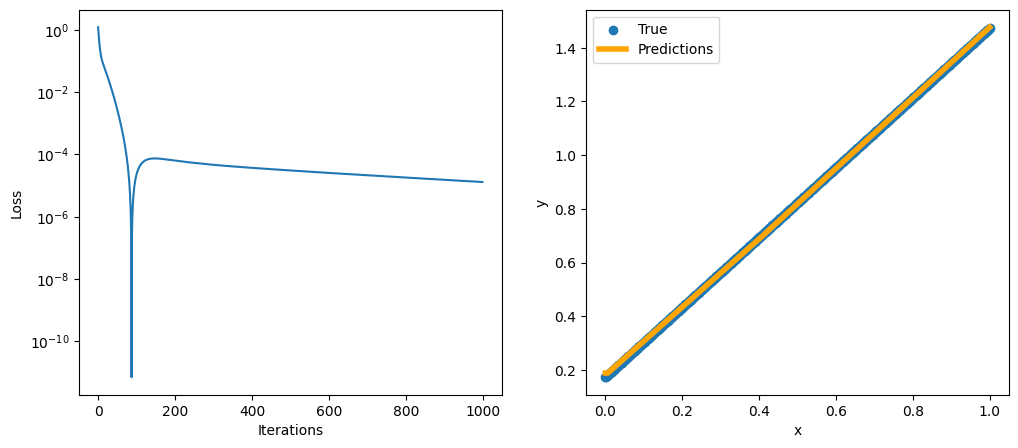

In [38]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the loss over time in the first subplot
ax1.plot(np.arange(iters), losses)
ax1.set_ylabel('Loss')
ax1.set_yscale("log")
ax1.set_xlabel('Iterations')

# Plot the true data and model predictions in the second subplot
ax2.scatter(x.squeeze().detach().numpy(), y, label='True')
with torch.no_grad():
    y_hat = mlp(x)
ax2.plot(x.squeeze().detach().numpy(), y_hat.squeeze().detach().numpy(), label='Predictions', color='orange', linewidth=4)
ax2.set_ylabel('y')
ax2.set_xlabel('x')
ax2.legend()

# Show the figure
plt.show()

In [39]:
#We can also use L1 Loss

In [40]:
# Define training loop for MLP
# we will use torch.optim optimizers instead of doing it by hand, as done in the linear regression model

lr = 3e-4
iters = 1000
losses = []

mlp = MLP()
opt = torch.optim.SGD(mlp.parameters(), lr=lr)
print("Number of parameters: ", sum(p.numel() for p in mlp.parameters()))

# tensor dimensions of mlp forward pass for this small network
# [1,1] * [1,5] + [1,5] () ReLU() * [5, 1] + [1,1] = [1,1]
#   x   *   m   +   b   () ReLU() *   m    +   b   = y_hat
#  input  ->   layer_1  ->  nonlin  ->   layer_2   = output

x = x.to(torch.float32).unsqueeze(-1) # x.shape [100]->[100,1] so mlp knows there are 100 samples of 1 scalar value (x)

mlp.train()
for _ in tqdm(range(iters)):
    for i in range(x.shape[0]):
        y_hat = mlp(x[i])
        J = F.l1_loss(y_hat.to(torch.float32).squeeze(), y_target[i].to(torch.float32))
        J.backward()
        opt.step()
        opt.zero_grad()
    losses.append(J.item())

Number of parameters:  16


100%|██████████| 1000/1000 [04:11<00:00,  3.97it/s]


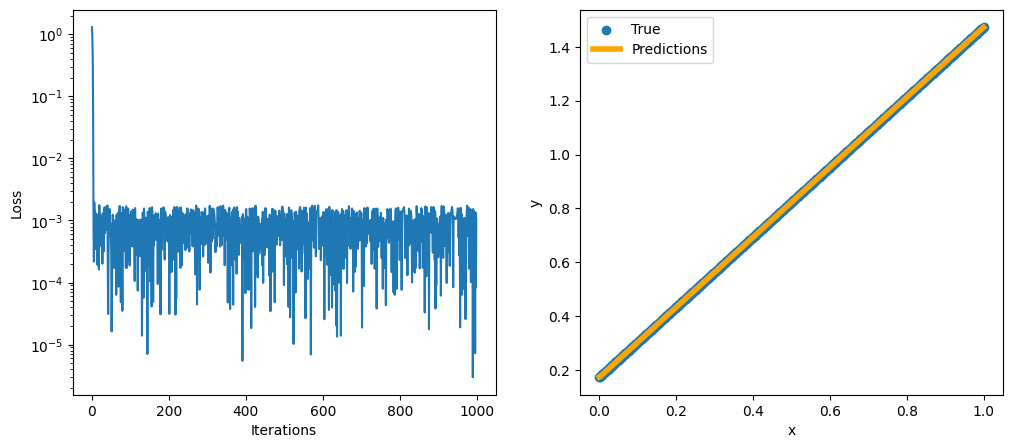

In [41]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the loss over time in the first subplot
ax1.plot(np.arange(iters), losses)
ax1.set_ylabel('Loss')
ax1.set_yscale("log")
ax1.set_xlabel('Iterations')

# Plot the true data and model predictions in the second subplot
ax2.scatter(x.squeeze().detach().numpy(), y, label='True')
with torch.no_grad():
    y_hat = mlp(x)
ax2.plot(x.squeeze().detach().numpy(), y_hat.squeeze().detach().numpy(), label='Predictions', color='orange', linewidth=4)
ax2.set_ylabel('y')
ax2.set_xlabel('x')
ax2.legend()

# Show the figure
plt.show()

In [42]:
# print(type(mlp))
print(mlp)
print("mlp.fc1.weight")
print(mlp.fc1.weight)
print("mlp.fc1.bias")
print(mlp.fc1.bias)
print("mlp.fc2.weight")
print(mlp.fc2.weight)
print("mlp.fc2.bias")
print(mlp.fc2.bias)

MLP(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)
mlp.fc1.weight
Parameter containing:
tensor([[ 0.4267],
        [-0.1252],
        [-0.0870],
        [ 1.0591],
        [ 1.1301]], requires_grad=True)
mlp.fc1.bias
Parameter containing:
tensor([-0.4179, -0.3555, -0.1283, -0.0027,  0.2918], requires_grad=True)
mlp.fc2.weight
Parameter containing:
tensor([[-0.1011,  0.3891,  0.2847,  0.5189,  0.6647]], requires_grad=True)
mlp.fc2.bias
Parameter containing:
tensor([-0.0200], requires_grad=True)


# Stochastic Gradient Descent
Above, we are computing the $\hat{y}$ prediction for each sample, and updating the parameters w.r.t. to that the loss computed for that single prediction. This is computationally inefficient and makes the network's optimization trajectory susceptible to OOD, or near-OOD samples. 
In practice, deep learning models are trained with __Stochastic__ Gradient Descent. All this means is we are going to compute __n__ number of predictions in parallel, and update the parameters of the model w.r.t. the average of those loss values. 

First, we will show the impact of training the network with a batch size (__n__) equal to the total number of samples in our toy dataset (500). This amounts to a small change in the code above, eliminating the inner-most for-loop. 

In [47]:
# Define training loop for MLP
# we will use torch.optim optimizers instead of doing it by hand, as done in the linear regression model

lr = 3e-4
iters = 1000
losses = []

mlp = MLP()
opt = torch.optim.SGD(mlp.parameters(), lr=lr)
print("Number of parameters: ", sum(p.numel() for p in mlp.parameters()))

mlp.train()
for _ in tqdm(range(iters)):
    y_hat = mlp(x)
    J = F.l1_loss(y_hat.to(torch.float32).squeeze(), y_target.to(torch.float32))
    J.backward()
    opt.step()
    opt.zero_grad()
    losses.append(J.item())

Number of parameters:  16


100%|██████████| 1000/1000 [00:00<00:00, 1949.16it/s]


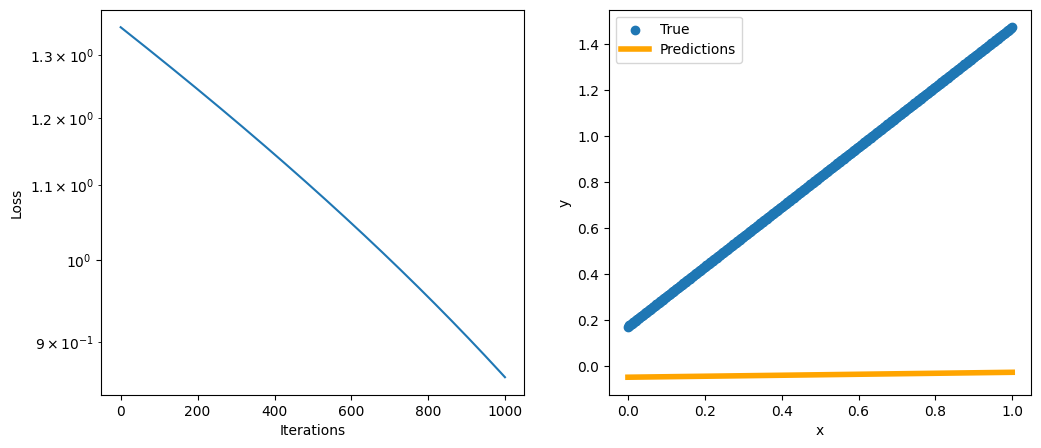

In [48]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the loss over time in the first subplot
ax1.plot(np.arange(iters), losses)
ax1.set_ylabel('Loss')
ax1.set_yscale("log")
ax1.set_xlabel('Iterations')

# Plot the true data and model predictions in the second subplot
ax2.scatter(x.squeeze().detach().numpy(), y, label='True')
with torch.no_grad():
    y_hat = mlp(x)
ax2.plot(x.squeeze().detach().numpy(), y_hat.squeeze().detach().numpy(), label='Predictions', color='orange', linewidth=4)
ax2.set_ylabel('y')
ax2.set_xlabel('x')
ax2.legend()

# Show the figure
plt.show()

Okay, so we can see above that our network didn't train properly, when using the same number of epochs (number of times the network goes through the dataset). __BUT__ The per-epoch time was substantially faster. 
The network didn't train, given the same number of epochs for a few reasons. 
* The network only updated its weights 1000 times, vs. 1000*500 for the gradient descent version.
* Since the network is being updated with the mean of 500 loss values the quality of the loss signal is lower.

So now, we still want to leverage the massive compute speed-ups by running multiple samples in parallel, but we also want a stronger loss signal, or a more 'meaningful' gradient. 
What happens if we drop the number of samples being run in parallel (reduce batch size)?

Batch Size * Number of Iterations = Total number of data point


In [49]:
# Define training loop for MLP
# we will use torch.optim optimizers instead of doing it by hand, as done in the linear regression model

lr = 3e-4
iters = 1000
losses = []

mlp = MLP()
opt = torch.optim.SGD(mlp.parameters(), lr=lr)
print("Number of parameters: ", sum(p.numel() for p in mlp.parameters()))

# define new hyperparameter: batch size
batch_size = 25

mlp.train()
for _ in tqdm(range(iters)):
    for i in range(x.shape[0]//batch_size):
        y_hat = mlp(x[i*batch_size:(i*batch_size)+batch_size])
        J = F.l1_loss(y_hat.to(torch.float32).squeeze(), y_target[i*batch_size:(i*batch_size)+batch_size].to(torch.float32))
        J.backward()
        opt.step()
        opt.zero_grad()
    losses.append(J.item())

Number of parameters:  16


100%|██████████| 1000/1000 [00:10<00:00, 95.07it/s]


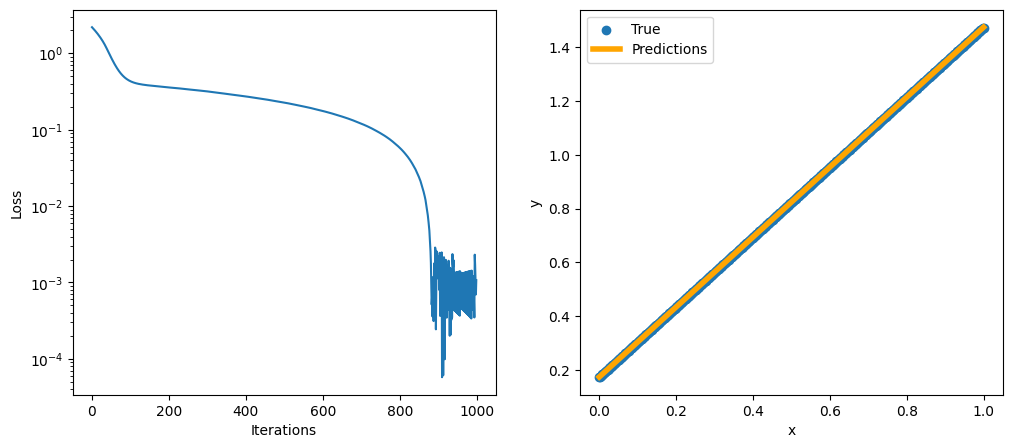

In [50]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the loss over time in the first subplot
ax1.plot(np.arange(iters), losses)
ax1.set_ylabel('Loss')
ax1.set_yscale("log")
ax1.set_xlabel('Iterations')

# Plot the true data and model predictions in the second subplot
ax2.scatter(x.squeeze().detach().numpy(), y, label='True')
with torch.no_grad():
    y_hat = mlp(x)
ax2.plot(x.squeeze().detach().numpy(), y_hat.squeeze().detach().numpy(), label='Predictions', color='orange', linewidth=4)
ax2.set_ylabel('y')
ax2.set_xlabel('x')
ax2.legend()

# Show the figure
plt.show()

Fantastic, with this reduced batch size we get the computational speed-ups from the parallelization, but with high-quality signals from the loss function. 

# Summary
So far we have briefly covered automatic differentiation in pytorch, how we can use it for a linear regression model and then how it is used in a simple MLP. Then we covered the basics of what gradient descent is and the impacts it can have while optimizing your model. We did all of this through the lense of regression, i.e., predicting a scalar value given some input. The other type of core example problem, and one prevalent in all of machine learning is classification. In classification, instead of predicting a scalar value on the number line we are going to predict some overarching classifying variable. We will do a brief example in 2D to build a basic intution for what it is and show you how simple it is to convert the above regression MLP to be used for classification!

### Classification
We will generate a small classification dataset like we did for the regression dataset above, change the MLP class appropriately, train and visualize the model.

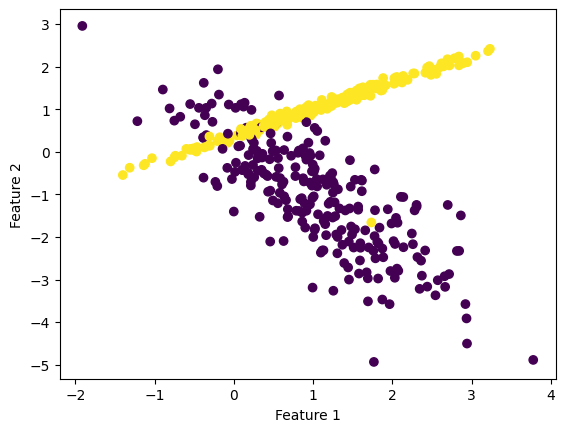

In [54]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Generate a random 2D classification dataset
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [55]:
# Define our small MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # input layer to hidden layer
        self.relu = nn.Tanh()       # tanh nonlinearity
        self.fc2 = nn.Linear(5, 2)  # hidden layer to output layer
        self.softmax = nn.Softmax(dim=1)  # softmax prediction raw score to prob dist over classes

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [58]:
from torchmetrics.classification import BinaryAccuracy
metric = BinaryAccuracy()
# Define training loop for MLP

# device = 

x = torch.tensor(X, dtype=torch.float32, requires_grad=True)
# one-hot encode our target var y
y_target = np.eye(2)[y]
y_target = torch.tensor(y_target, dtype=torch.float32, requires_grad=True)

lr = 3e-4
iters = 5000
losses = []
accuracies = []

mlp = MLP()
opt = torch.optim.SGD(mlp.parameters(), lr=lr)
print("Number of parameters: ", sum(p.numel() for p in mlp.parameters()))

# define new hyperparameter: batch size
batch_size = 25

mlp.train()
for _ in tqdm(range(iters)):
    for i in range(x.shape[0]//batch_size):
        y_hat = mlp(x[i*batch_size:(i*batch_size)+batch_size])
        J = F.l1_loss(y_hat.to(torch.float32).squeeze(), y_target[i*batch_size:(i*batch_size)+batch_size].to(torch.float32))
        J.backward()
        opt.step()
        opt.zero_grad()
    losses.append(J.item())
    accuracies.append(metric(y_hat, y_target[i*batch_size:(i*batch_size)+batch_size]).item())

Number of parameters:  27


100%|██████████| 5000/5000 [00:56<00:00, 87.92it/s]


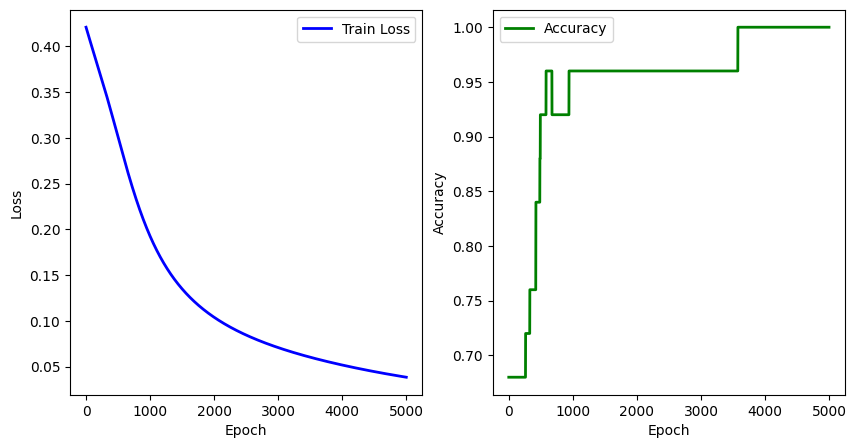

In [59]:
# Init figure w/ subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training loss curve in the first subplot
ax1.plot(losses, label='Train Loss', color='blue', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the accuracy curve in the second subplot
ax2.plot(accuracies, label='Accuracy', color='green', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()